In [1]:
!pip install underthesea==6.8.4
!pip install scikit-learn==1.5.2
!pip install pandas numpy matplotlib seaborn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 87.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [3]:
# Các nhãn cần phân loại
target_columns = [
    'Emotional Reasoning', 'Overgeneralization', 'Should Statements',
    'Personalization', 'Mental Filter', 'Disqualifying the Positive',
    'Jumping to Conclusions', 'Labeling and Mislabeling',
    'Magnification and Minimization', 'All-or-Nothing Thinking'
]

In [4]:
# ====================== PREPROCESS ======================
def preprocess(df, feature_type, add_labels=None):
    df = df.copy()
    
    # Xóa cột text
    text_cols = [c for c in df.columns if 'text' in c.lower()]
    df.drop(columns=text_cols, inplace=True, errors='ignore')

    # Nếu cần thêm các nhãn từ file khác
    if add_labels is not None:
        for col in target_columns:
            if col not in df.columns:
                df[col] = add_labels[col]

    # Encode cột object
    for c in df.columns:
        if df[c].dtype == 'object' and c not in target_columns:
            df[c] = LabelEncoder().fit_transform(df[c].astype(str))
        else:
            try:
                df[c] = df[c].astype(float)
            except:
                pass

    return df

# ====================== RUN EXPERIMENT ======================
def run_experiment_multi(df, feature_name):
    print(f"\n==================== {feature_name.upper()} ====================")
    results = []

    for target in target_columns:
        X = df.drop(columns=target_columns)
        y = df[target]

        # Encode nhãn nếu là object
        if y.dtype == 'object':
            y = LabelEncoder().fit_transform(y.astype(str))

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Logistic
        clf1 = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42)
        clf1.fit(X_train_scaled, y_train)
        y_pred1 = clf1.predict(X_test_scaled)
        f1_micro1 = f1_score(y_test, y_pred1, average="micro")
        f1_macro1 = f1_score(y_test, y_pred1, average="macro")
        results.append({
            "Feature": feature_name,
            "Model": "Logistic",
            "Target": target,
            "F1-micro": f1_micro1,
            "F1-macro": f1_macro1
        })

        # RandomForest
        clf2 = RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=42)
        clf2.fit(X_train, y_train)
        y_pred2 = clf2.predict(X_test)
        f1_micro2 = f1_score(y_test, y_pred2, average="micro")
        f1_macro2 = f1_score(y_test, y_pred2, average="macro")
        results.append({
            "Feature": feature_name,
            "Model": "RandomForest",
            "Target": target,
            "F1-micro": f1_micro2,
            "F1-macro": f1_macro2
        })

    return pd.DataFrame(results)

In [5]:
lexical = pd.read_csv("/kaggle/input/cogdis-data/lexical_features.csv")
syntactic = pd.read_csv("/kaggle/input/cogdis-data/syntactic_features.csv")
sentiment = pd.read_csv("/kaggle/input/cogdis-data/Sentiment Emotion Features.csv")
interaction = pd.read_csv("/kaggle/input/cogdis-data/Interaction_features.csv")
semantic = pd.read_csv("/kaggle/input/cogdis-data/Semantic_features_phobert_10bias.csv")

In [6]:
# ====================== THÊM LABEL CHO NHỮNG FILE THIẾU ======================
lexical_proc = preprocess(lexical, "Lexical")
syntactic_proc = preprocess(syntactic, "Syntactic", add_labels=lexical)
sentiment_proc = preprocess(sentiment, "Sentiment", add_labels=lexical)
interaction_proc = preprocess(interaction, "Interaction", add_labels=lexical)
semantic_proc = preprocess(semantic, "Semantic", add_labels=lexical)

datasets = {
    "Lexical": lexical_proc,
    "Syntactic": syntactic_proc,
    "Sentiment": sentiment_proc,
    "Interaction": interaction_proc,
    "Semantic": semantic_proc
}

In [7]:
# ====================== CHẠY EXPERIMENT ======================
all_results = []
for name, df in datasets.items():
    try:
        res = run_experiment_multi(df, name)
        all_results.append(res)
    except Exception as e:
        print(f"❌ Lỗi khi xử lý {name}: {e}")


==================== LEXICAL ====================

==================== SYNTACTIC ====================

==================== SENTIMENT ====================

==================== INTERACTION ====================

==================== SEMANTIC ====================


In [8]:
results_df = pd.concat(all_results, ignore_index=True)
results_df.to_csv("feature_vs_each_cognitive_bias.csv", index=False)
print(results_df)

     Feature         Model                          Target  F1-micro  F1-macro
0    Lexical      Logistic             Emotional Reasoning  0.761881  0.569671
1    Lexical  RandomForest             Emotional Reasoning  0.938791  0.484215
2    Lexical      Logistic              Overgeneralization  0.759144  0.583714
3    Lexical  RandomForest              Overgeneralization  0.930829  0.509262
4    Lexical      Logistic               Should Statements  0.936054  0.779007
..       ...           ...                             ...       ...       ...
95  Semantic  RandomForest        Labeling and Mislabeling  0.882558  0.701815
96  Semantic      Logistic  Magnification and Minimization  0.690719  0.511109
97  Semantic  RandomForest  Magnification and Minimization  0.966410  0.776974
98  Semantic      Logistic         All-or-Nothing Thinking  0.633740  0.490120
99  Semantic  RandomForest         All-or-Nothing Thinking  0.938293  0.484082

[100 rows x 5 columns]


<Figure size 1600x600 with 0 Axes>

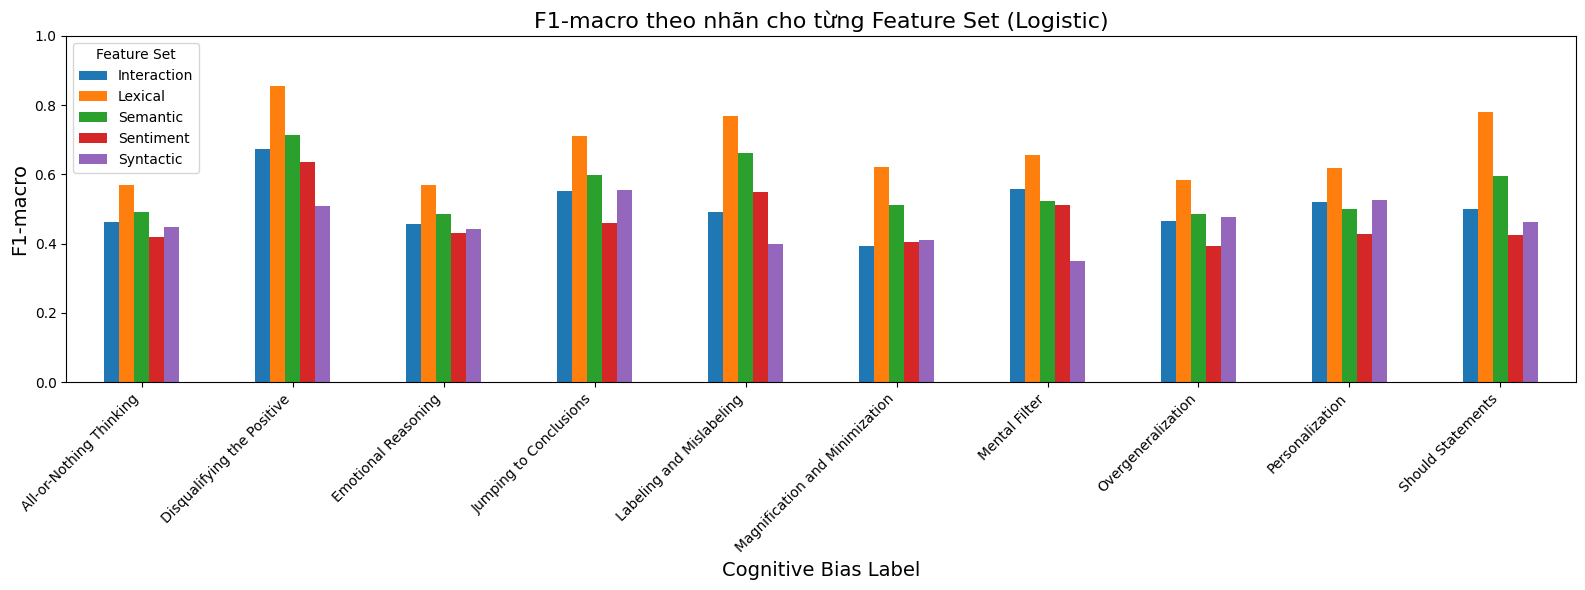

<Figure size 1600x600 with 0 Axes>

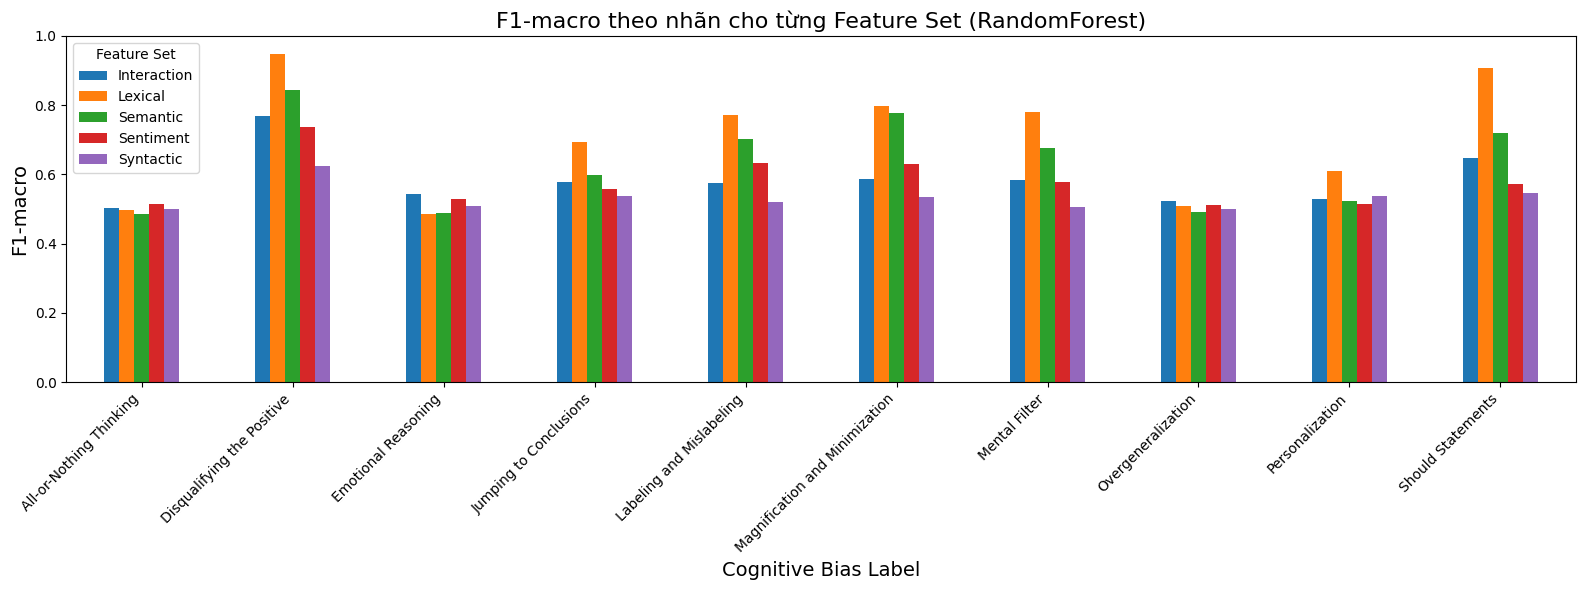

<Figure size 1600x600 with 0 Axes>

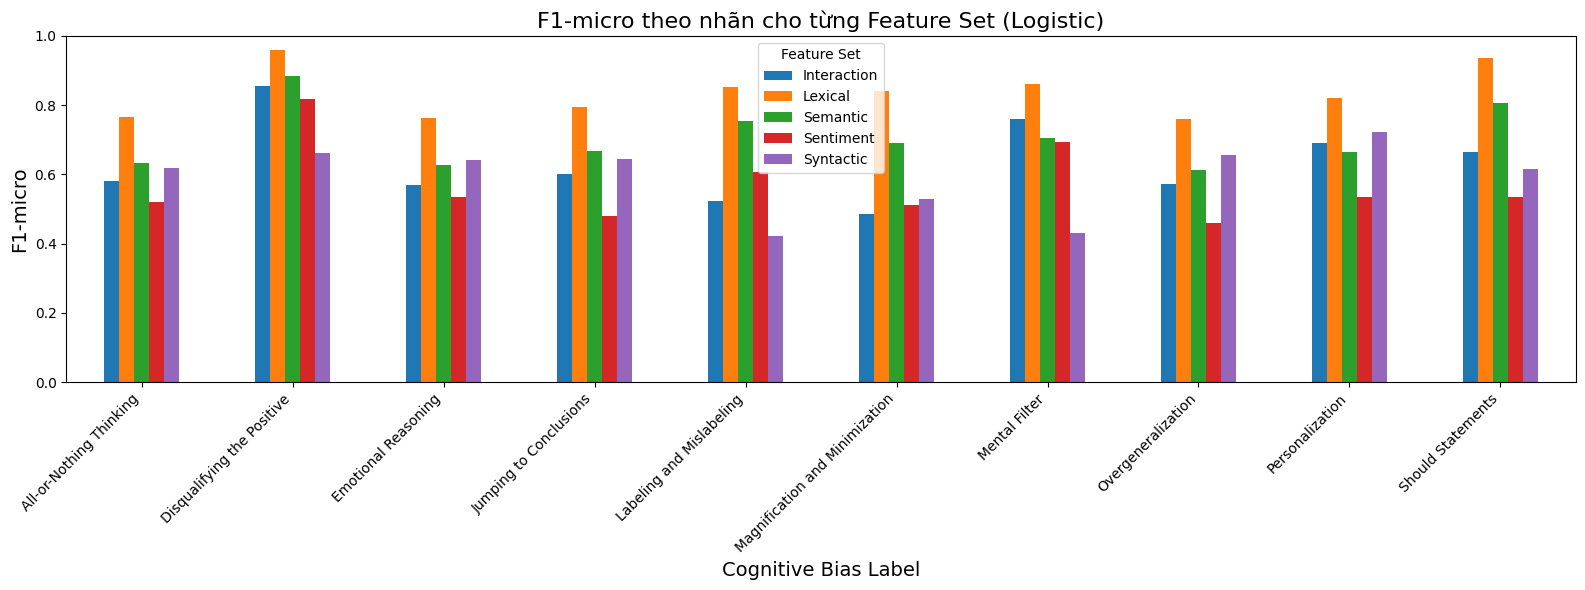

<Figure size 1600x600 with 0 Axes>

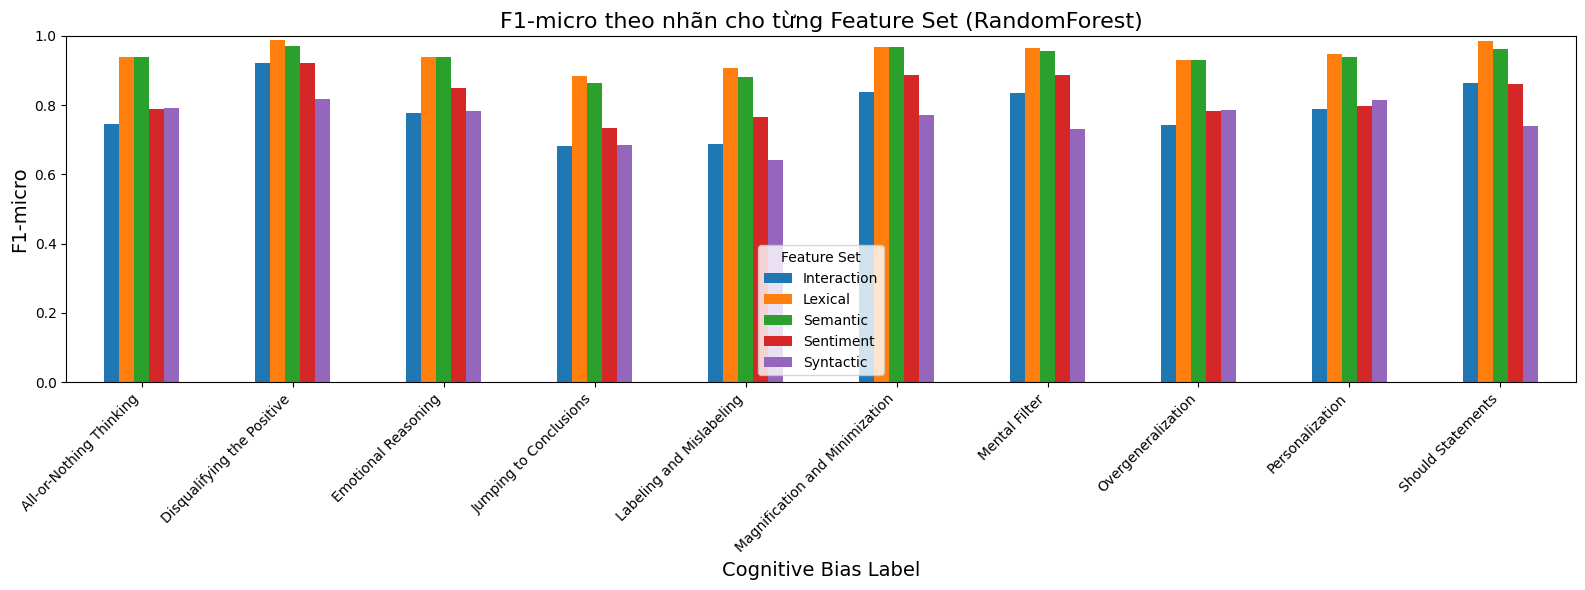

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# ====================== VISUALIZE ======================
# Chia theo Model (Logistic / RandomForest)
for model in results_df['Model'].unique():
    plt.figure(figsize=(16,6))
    df_plot = results_df[results_df['Model'] == model]
    
    # Pivot dữ liệu để dễ plot
    df_pivot = df_plot.pivot(index='Target', columns='Feature', values='F1-macro')
    df_pivot.plot(kind='bar', figsize=(16,6))
    
    plt.title(f'F1-macro theo nhãn cho từng Feature Set ({model})', fontsize=16)
    plt.ylabel('F1-macro', fontsize=14)
    plt.xlabel('Cognitive Bias Label', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.legend(title='Feature Set')
    plt.tight_layout()
    plt.show()

# Nếu muốn tổng quan cho F1-micro
for model in results_df['Model'].unique():
    plt.figure(figsize=(16,6))
    df_plot = results_df[results_df['Model'] == model]
    
    df_pivot = df_plot.pivot(index='Target', columns='Feature', values='F1-micro')
    df_pivot.plot(kind='bar', figsize=(16,6))
    
    plt.title(f'F1-micro theo nhãn cho từng Feature Set ({model})', fontsize=16)
    plt.ylabel('F1-micro', fontsize=14)
    plt.xlabel('Cognitive Bias Label', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.legend(title='Feature Set')
    plt.tight_layout()
    plt.show()
